In [1]:
from pylsl import StreamInlet, resolve_stream
import numpy as np
import pandas as pd

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold
import matplotlib.pyplot as plt

from scipy import stats

import time

#from volume_control import volume_up,  volume_down, volume_on, volume_off

#### functions for feature calculations

In [2]:
def rms(values):
    return np.sqrt(np.sum(np.square(values))/len(values))

def mav(values):
    return np.sum(np.absolute(values))/len(values)    

def var(values):
    return np.sum(np.square(values))/(len(values)-1)

def wl_exp(values):
    wavelen = np.sum(np.abs(values[:-1]-values[1:]))
    return wavelen

def wl(values):
    val_array = values.to_numpy()
    wavelen = np.sum(np.abs(val_array[:-1]-val_array[1:]))
    return wavelen

def zc(values):
    val_array = values.to_numpy()
    zero_crossings = np.where(np.diff(np.signbit(val_array)))[0]
    return len(zero_crossings)

def zc_exp(values):
    val_array = values.to_numpy()
    zero_crossings = np.where(np.diff(np.signbit(val_array)))[0]
    return len(zero_crossings)

### TRAINING

- set current device and subject_ID

In [3]:
def read_from_file(file: str):
    data = pd.read_csv(file)
    return data.loc[data["direction"] > 0]

path_lg = '/Users/lukasgehrke/Documents/publications/proxEMG/data/4_chan/'
path_nw = 'C:/Users/Nils/Documents/02_Uni/Master Human Factors/\
00_Masterarbeit/55_github/proxEMG/data/user_study/'
path_mac_old = '/Users/work/Desktop/Nils/study/4_chan/'
path_mac = '/Users/work/Desktop/Nils/proxEMG/data/user_study/'

device = path_nw
subject_id = '00_final_pre'

path_rot = device + subject_id + '/' + subject_id + '_training_rotation.csv'
path_ges = device + subject_id + '/' + subject_id + '_training_gesture.csv'

In [4]:
def feature_calculation(data:pd.DataFrame, win_size=None, baseline=False, baseline_size=1):
    df = pd.DataFrame()
    n_epoch = data['epoch_ixs'].max()
    
    for i in range(1,n_epoch+1):
        
        data_curr = data[data['epoch_ixs']==i]

        if win_size is not None: # get middle window
            middle_t = (len(data_curr)-1) / 2
            start_t = int(np.floor(middle_t - win_size/2))
            end_t = int(np.floor(middle_t + win_size/2))
            data_curr = data_curr[start_t:end_t]

        if baseline:
            base = data_curr.iloc[0:baseline_size,2:].mean()
            data_curr.iloc[:,2:] = data_curr.iloc[:,2:] - base
        
        # df_curr = data_curr[:win_size].filter(muscles_list[:-1]).agg(features_selected).melt().transpose()[-1:]
        df_curr = data_curr.filter(muscles_list).agg(features_selected).melt().transpose()[-1:]
        df_curr['direction'] = data_curr.direction.values[0]
        
        df = pd.concat([df,df_curr], axis=0, ignore_index=True)
        #print(i)
    
    return df

#### feature calculation and data preparation

In [5]:
%%time

windowsize = 250
baselinesize = windowsize

features_selected = [rms,mav,var, wl,zc]
#features_selected = [mav, var, wl]
#features_selected = [wl, mav, var]
muscles_list = ["muscle1","muscle2", "muscle3","muscle4"]
# muscles_list = ["muscle1","muscle2", "muscle3"] 

# overlap = 0.2
# stepsize = windowsize - int(overlap*windowsize)
# muscles_list = ["muscle2", "muscle3"]

import warnings
warnings.filterwarnings('ignore')

all_data_rot = feature_calculation(read_from_file(file=path_rot), win_size=windowsize, baseline=True, baseline_size=baselinesize)
all_data_ges = feature_calculation(read_from_file(file=path_ges), win_size=windowsize, baseline=True, baseline_size=baselinesize)

Wall time: 5.55 s


In [6]:
# zusammenfassen von no_rot_left & no_rot_right
all_data_rot['direction'] = all_data_rot['direction'].replace([4],[3])

# check class sizes
freq_rot = all_data_rot['direction'].value_counts() 
freq_ges = all_data_ges['direction'].value_counts()

# sample all classes to smallest class size
sample_data_ges = all_data_ges.groupby('direction').sample(n=min(freq_ges), random_state=42)
sample_data_rot = all_data_rot.groupby('direction').sample(n=min(freq_rot), random_state=42)

### TESTING

In [7]:
def LDA_with_CV(data: pd.DataFrame, folds = 10):
    #clf=LDA('lsqr',shrinkage='auto')
    clf=LDA()
    kfolds = KFold(n_splits=folds, random_state=1, shuffle=True)
    
    X_train = data.iloc[:,1:len(data.columns)].values
    y_train = data.direction
    
    cv_results = cross_val_score(clf, X_train, y_train, cv=kfolds)

    print("%0.3f accuracy with a standard deviation of %0.3f using %0.f-folds-CV" % (cv_results.mean(), cv_results.std(),folds))

In [8]:
def testing(data: pd.DataFrame, testsize = 0.25):
    clf=LDA()
    X = data.iloc[:,1:len(data.columns)].values
    y = data.direction
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsize, random_state=42)
    
    clf.fit(X_train, y_train)
    test_result = clf.score(X_test,y_test)
    
    print("%0.3f accuracy with a test_size of %0.2f" % (test_result, testsize))  

testing:
<br>
- LDA_with_CV: LDA with cross validation; optional parameter folds (default 10)
- testing: LDA with train-test-split; optional parameter testsize (default 0.25)

In [9]:
LDA_with_CV(sample_data_ges)
LDA_with_CV(sample_data_rot,folds=5)

testing(sample_data_ges)
testing(sample_data_rot)

1.000 accuracy with a standard deviation of 0.000 using 10-folds-CV
0.880 accuracy with a standard deviation of 0.098 using 5-folds-CV
1.000 accuracy with a test_size of 0.25
1.000 accuracy with a test_size of 0.25


## SFS

In [10]:
# first stage
rms_set = sample_data_rot.iloc[:,[0,5,10,15,20]]
mav_set = sample_data_rot.iloc[:,[1,6,11,16,20]]
var_set = sample_data_rot.iloc[:,[2,7,12,17,20]]
wl_set = sample_data_rot.iloc[:,[3,8,13,18,20]] 
zc_set = sample_data_rot.iloc[:,[4,9,14,19,20]]


print("RMS")
LDA_with_CV(rms_set)
testing(rms_set)

print("MAV")
LDA_with_CV(mav_set)
testing(mav_set)

print("VAR")
LDA_with_CV(var_set)
testing(var_set)

print("WL")
LDA_with_CV(wl_set)
testing(wl_set)

print("ZC")
LDA_with_CV(zc_set)
testing(zc_set)

RMS
0.518 accuracy with a standard deviation of 0.191 using 10-folds-CV
0.474 accuracy with a test_size of 0.25
MAV
0.477 accuracy with a standard deviation of 0.197 using 10-folds-CV
0.421 accuracy with a test_size of 0.25
VAR
0.577 accuracy with a standard deviation of 0.155 using 10-folds-CV
0.421 accuracy with a test_size of 0.25
WL
0.607 accuracy with a standard deviation of 0.170 using 10-folds-CV
0.737 accuracy with a test_size of 0.25
ZC
0.598 accuracy with a standard deviation of 0.135 using 10-folds-CV
0.579 accuracy with a test_size of 0.25


In [11]:
# second stage
wl_rms_set = sample_data_rot.iloc[:,[3,8,13,18,0,5,10,15,20]]
wl_mav_set = sample_data_rot.iloc[:,[3,8,13,18,1,6,11,16,20]]
wl_var_set = sample_data_rot.iloc[:,[3,8,13,18,2,7,12,17,20]]
#wl_set = sample_data_rot.iloc[:,[3,8,13,18,20]] 
wl_zc_set = sample_data_rot.iloc[:,[3,8,13,18,4,9,14,19,20]]

print("WL + RMS")
LDA_with_CV(wl_rms_set)
testing(wl_rms_set)

print("WL + MAV")
LDA_with_CV(wl_mav_set)
testing(wl_mav_set)

print("WL + VAR")
LDA_with_CV(wl_var_set)
testing(wl_var_set)

print("WL + ZC")
LDA_with_CV(wl_zc_set)
testing(wl_zc_set)

WL + RMS
0.800 accuracy with a standard deviation of 0.137 using 10-folds-CV
0.947 accuracy with a test_size of 0.25
WL + MAV
0.812 accuracy with a standard deviation of 0.126 using 10-folds-CV
0.947 accuracy with a test_size of 0.25
WL + VAR
0.736 accuracy with a standard deviation of 0.126 using 10-folds-CV
0.842 accuracy with a test_size of 0.25
WL + ZC
0.709 accuracy with a standard deviation of 0.162 using 10-folds-CV
0.947 accuracy with a test_size of 0.25


In [12]:
# third stage 
wl_mav_rms_set = sample_data_rot.iloc[:,[3,8,13,18,1,6,11,16,0,5,10,15,20]]
#wl_mav_set = sample_data_rot.iloc[:,[3,8,13,18,1,6,11,16,20]]
wl_mav_var_set = sample_data_rot.iloc[:,[3,8,13,18,1,6,11,16,2,7,12,17,20]]
#wl_set = sample_data_rot.iloc[:,[3,8,13,18,20]] 
wl_mav_zc_set = sample_data_rot.iloc[:,[3,8,13,18,1,6,11,16,4,9,14,19,20]]

print("WL + MAV + RMS")
LDA_with_CV(wl_mav_rms_set)
testing(wl_mav_rms_set)

print("WL + MAV + VAR")
LDA_with_CV(wl_mav_var_set)
testing(wl_mav_var_set)

print("WL + MAV + ZC")
LDA_with_CV(wl_mav_zc_set)
testing(wl_mav_zc_set)

WL + MAV + RMS
0.802 accuracy with a standard deviation of 0.145 using 10-folds-CV
0.842 accuracy with a test_size of 0.25
WL + MAV + VAR
0.855 accuracy with a standard deviation of 0.134 using 10-folds-CV
0.947 accuracy with a test_size of 0.25
WL + MAV + ZC
0.841 accuracy with a standard deviation of 0.137 using 10-folds-CV
0.947 accuracy with a test_size of 0.25


In [13]:
# fourth stage

wl_mav_var_rms_set = sample_data_rot.iloc[:,[3,8,13,18,1,6,11,16,2,7,12,17,0,5,10,15,20]]
wl_mav_var_zc_set = sample_data_rot.iloc[:,[3,8,13,18,1,6,11,16,2,7,12,17,4,9,14,19,20]]

print("WL + MAV + VAR + RMS")
LDA_with_CV(wl_mav_var_rms_set)
testing(wl_mav_var_rms_set)


print("WL + MAV + VAR + ZC")
LDA_with_CV(wl_mav_var_zc_set)
testing(wl_mav_var_zc_set)


WL + MAV + VAR + RMS
0.866 accuracy with a standard deviation of 0.085 using 10-folds-CV
0.895 accuracy with a test_size of 0.25
WL + MAV + VAR + ZC
0.814 accuracy with a standard deviation of 0.142 using 10-folds-CV
1.000 accuracy with a test_size of 0.25


In [16]:
# fifth stage

wl_mav_var_rms_zc_set = sample_data_rot.iloc[:,[3,8,13,18,1,6,11,16,2,7,12,17,0,5,10,15,4,9,14,19,20]]

print("WL + MAV + VAR + RMS + ZC")
LDA_with_CV(wl_mav_var_rms_zc_set)
testing(wl_mav_var_rms_zc_set)

WL + MAV + VAR + RMS + ZC
0.896 accuracy with a standard deviation of 0.095 using 10-folds-CV
1.000 accuracy with a test_size of 0.25


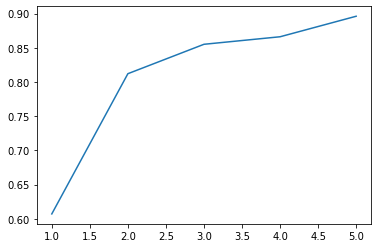

In [21]:
y = [0.607,0.812,0.855,0.866,0.896]
x = [1,2,3,4,5]

plt.plot(x,y)